In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, jaccard_score
from tqdm import tqdm
import matplotlib.pyplot as plt

Mounted at /content/drive


In [3]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 8
EPOCHS = 20

In [4]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

In [5]:
def iou_coef(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Binarize predictions

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3]) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return tf.reduce_mean(iou)

In [6]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
    return 1 - dice

def iou_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return 1 - iou

In [7]:
def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred) + iou_loss(y_true, y_pred)

In [8]:
model_path = '/content/drive/MyDrive/tf_models/Dental_mkIV.h5'
model = tf.keras.models.load_model(model_path, custom_objects={
        'dice_coef': dice_coef,
        'iou_coef': iou_coef,
        'combined_loss': combined_loss,
        'dice_loss': dice_loss,
        'iou_loss': iou_loss})

In [ ]:
base_path = '/content/drive/MyDrive/Binary masks'

train_image_path = os.path.join(base_path, 'train/images')
train_mask_path = os.path.join(base_path, 'train/masks')

valid_image_path = os.path.join(base_path, 'valid/images')
valid_mask_path = os.path.join(base_path, 'valid/masks')

test_image_path = os.path.join(base_path, 'test/images')
test_mask_path = os.path.join(base_path, 'test/masks')

In [ ]:
def load_dataset(image_dir, mask_dir):
    images = []
    masks = []

    for img_filename in sorted(os.listdir(image_dir)):
        # Construct full path for image
        image_path = os.path.join(image_dir, img_filename)

        # Construct corresponding mask filename
        base_name = os.path.splitext(img_filename)[0]
        mask_filename = f"{base_name}_mask.png"
        mask_path = os.path.join(mask_dir, mask_filename)

        # Skip if corresponding mask not found
        if not os.path.exists(mask_path):
            print(f"Mask not found for image: {img_filename}")
            continue

        # Read and process image
        img = cv2.imread(image_path)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        img = img / 255.0

        # Read and process mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
        mask = (mask > 127).astype(np.float32)

        images.append(img)
        masks.append(np.expand_dims(mask, axis=-1))

    return np.array(images), np.array(masks)

In [ ]:
train_images, train_masks = load_dataset(train_image_path, train_mask_path)
valid_images, valid_masks = load_dataset(valid_image_path, valid_mask_path)
test_images, test_masks = load_dataset(test_image_path, test_mask_path)

2/2 ━━━━━━━━━━━━━━━━━━━━ 109s 40s/step


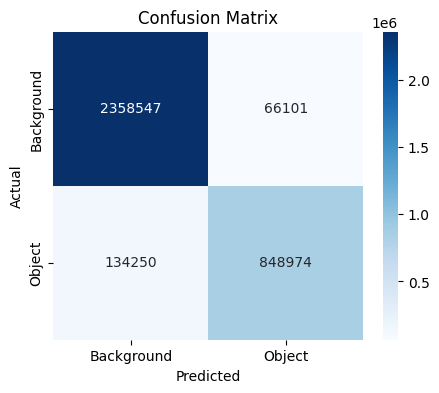

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, test_images, test_masks):
    # Step 1: Predict masks
    preds = model.predict(test_images)
    preds = (preds > 0.5).astype(np.uint8)

    # Step 2: Flatten ground truth and predictions
    y_true = test_masks.flatten()
    y_pred = preds.flatten()

    # Step 3: Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Step 4: Plot
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Background', 'Object'], yticklabels=['Background', 'Object'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# 🔍 Plot confusion matrix
plot_confusion_matrix(model, test_images, test_masks)

In [ ]:
import random

def display_predictions(model, test_images, test_masks, num_samples=5):
    indices = random.sample(range(len(test_images)), num_samples)

    for i in indices:
        image = test_images[i]
        true_mask = test_masks[i].squeeze()
        pred_mask = model.predict(np.expand_dims(image, axis=0))[0].squeeze()

        # Threshold the predicted mask
        pred_mask = (pred_mask > 0.5).astype(np.uint8)

        # Plot
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Test Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(true_mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


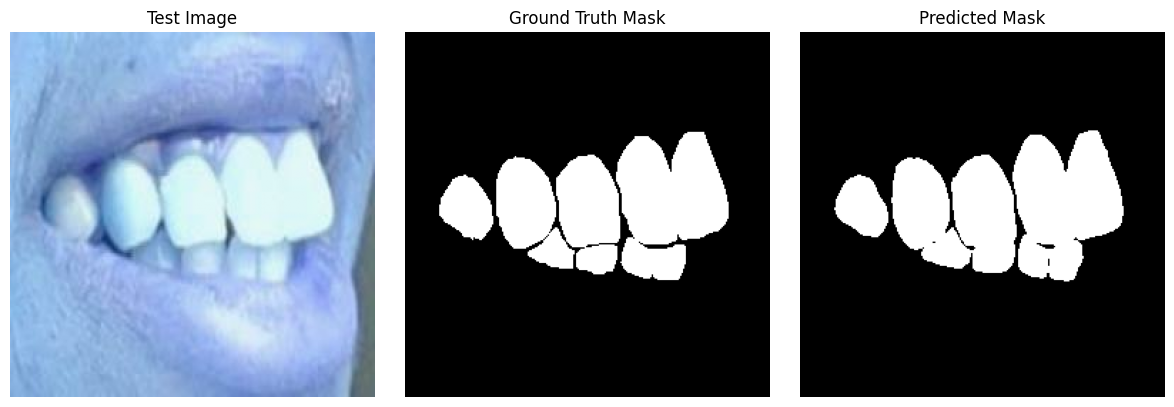

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


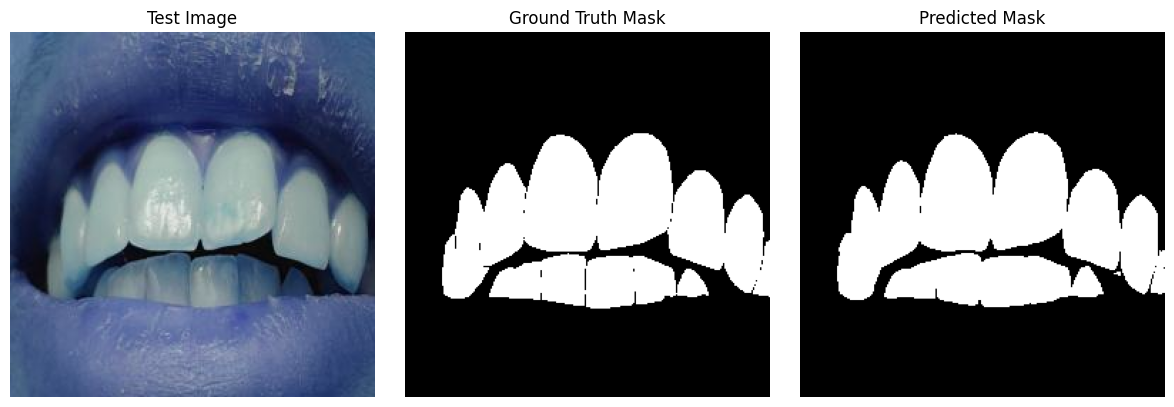

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


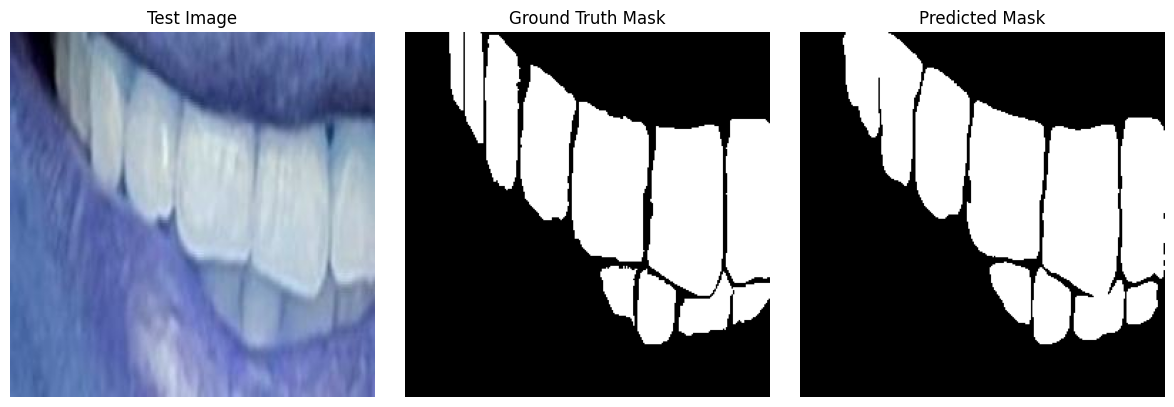

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


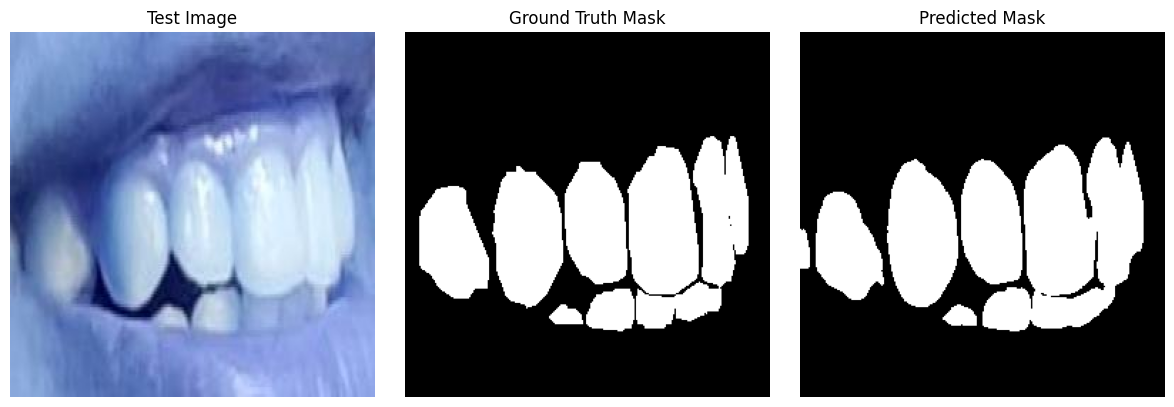

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


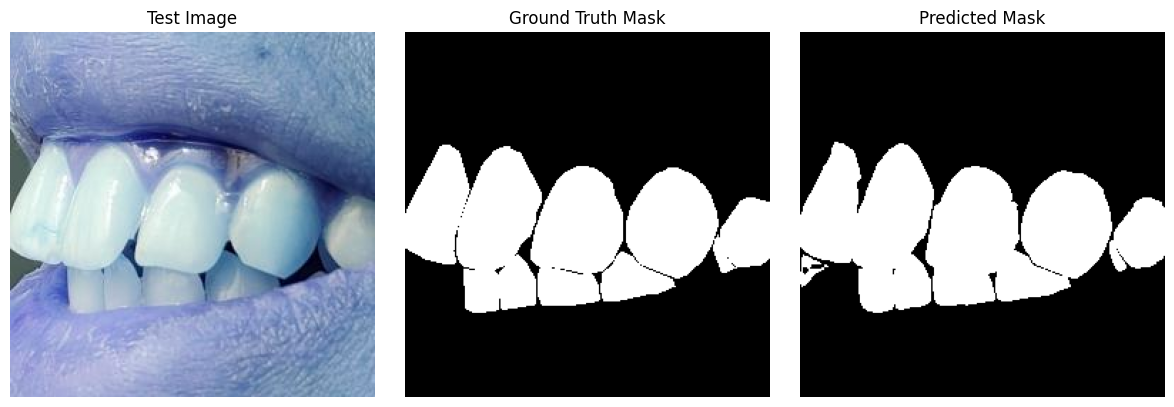

In [ ]:
display_predictions(model, test_images, test_masks, num_samples=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


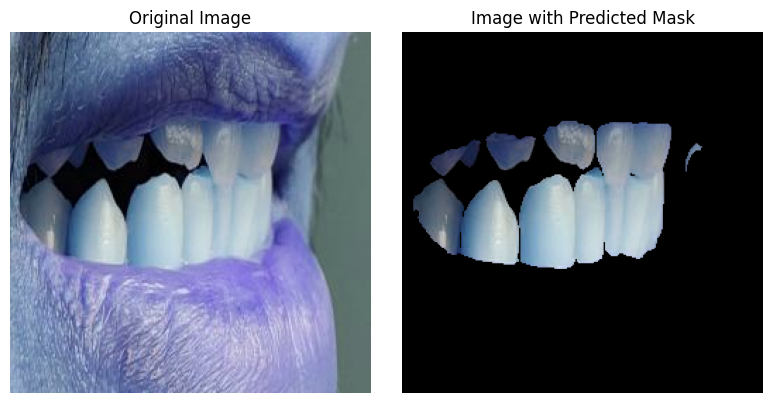

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


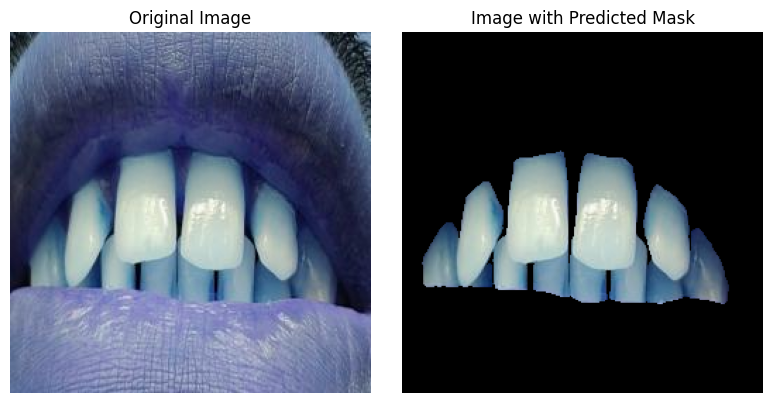

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


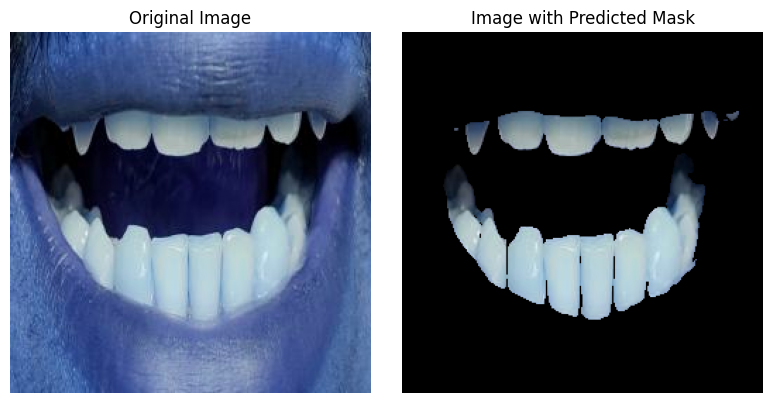

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


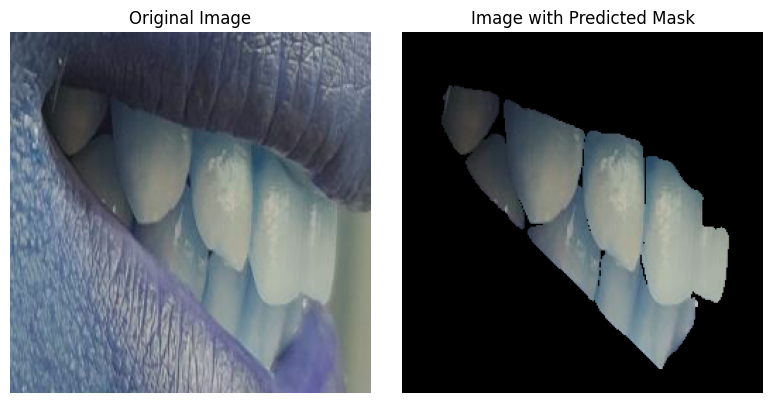

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


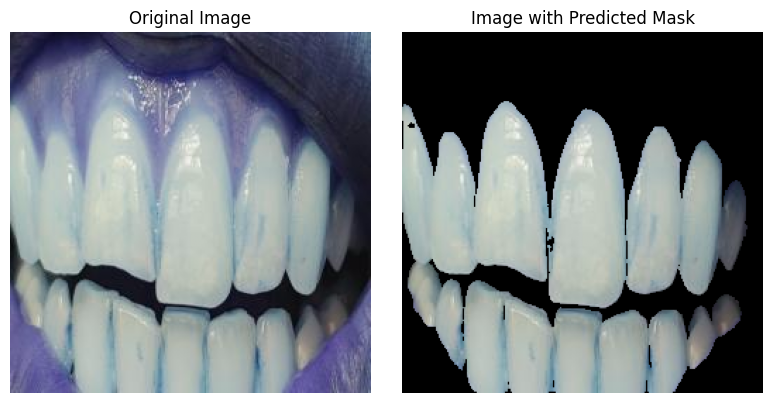

In [ ]:
# prompt: write code to display images after applying masks predicted by the model

import matplotlib.pyplot as plt
import numpy as np
def display_masked_images(model, test_images, num_samples=5):
    indices = random.sample(range(len(test_images)), num_samples)

    for i in indices:
        image = test_images[i]
        pred_mask = model.predict(np.expand_dims(image, axis=0))[0].squeeze()

        # Threshold the predicted mask
        pred_mask = (pred_mask > 0.5).astype(np.uint8)

        # Apply the predicted mask to the image
        # Create a 3-channel mask for element-wise multiplication
        pred_mask_3channel = np.stack([pred_mask, pred_mask, pred_mask], axis=-1)
        masked_image = image * pred_mask_3channel

        # Plot
        plt.figure(figsize=(8, 4))

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(masked_image)
        plt.title("Image with Predicted Mask")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

# Display images with applied predicted masks
display_masked_images(model, test_images, num_samples=5)


In [26]:
from PIL import Image

image_path = '6.jpeg'
img_size = (256, 256)

original_image = Image.open(image_path).convert('RGB')
resized_img = original_image.resize(img_size)
image_resized = original_image.resize(img_size)
image_array = np.array(image_resized) / 255.0

input_image = np.expand_dims(image_array, axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


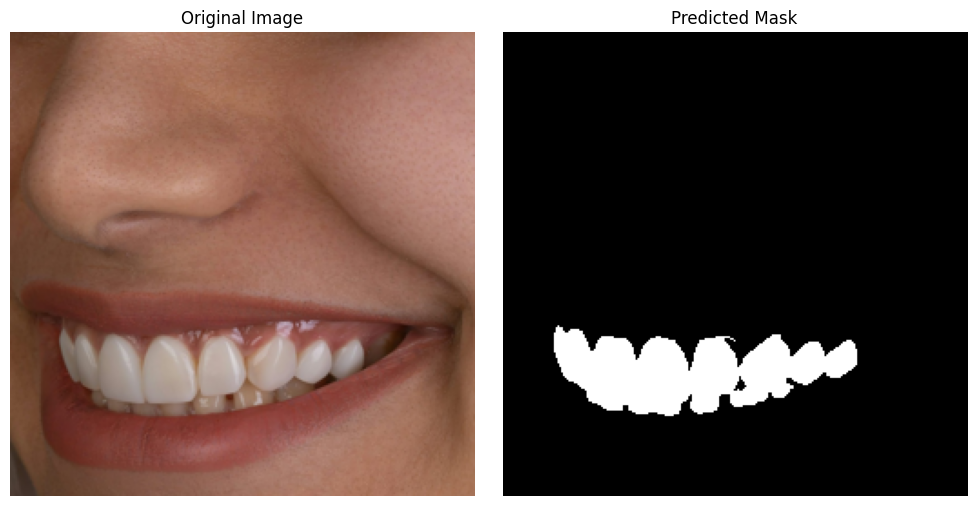

In [27]:
pred_mask = model.predict(input_image)[0]  # Remove batch dimension

# --- Post-process mask ---
if pred_mask.shape[-1] > 1:
    # Multi-class: argmax across channels
    pred_mask = np.argmax(pred_mask, axis=-1)
else:
    # Binary: apply threshold
    pred_mask = (pred_mask[:, :, 0] > 0.5).astype(np.uint8)

# --- Display results ---
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_resized)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(pred_mask, cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.tight_layout()
plt.show()